In [7]:
! wget http://dl.deepnn.ir/Diverse_hand_gesture_dataset.zip

Mounted at /content/drive


In [8]:
!unzip -qq Diverse_hand_gesture_dataset.zip

Imports

In [82]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
import pathlib
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

Load the data

In [10]:
data_dir = pathlib.Path('./train')

In [11]:
data_dir

PosixPath('train')

In [12]:
list_d = tf.data.Dataset.list_files(str(data_dir/'*.png'), shuffle=False)

In [13]:
image_count = tf.data.experimental.cardinality(list_d).numpy()
image_count

6400

In [14]:
for i in list_d.take(5):
    print(i)

tf.Tensor(b'train/1.png', shape=(), dtype=string)
tf.Tensor(b'train/10.png', shape=(), dtype=string)
tf.Tensor(b'train/100.png', shape=(), dtype=string)
tf.Tensor(b'train/1000.png', shape=(), dtype=string)
tf.Tensor(b'train/1001.png', shape=(), dtype=string)


In [15]:
pd.read_csv('train/1.txt', sep=' ')

,0,0.511161,0.562500,0.245536,0.312500


In [16]:
labels = []
bboxes = []

In [17]:
all_files = os.listdir('./train')
txt_files = [f for f in all_files if f.endswith('.txt')]

In [18]:
txt_files.sort()
txt_files[1]

'10.txt'

In [19]:
for i in txt_files:
    path = 'train/{}'.format(i)
    l, x1, y1, x2, y2 = pd.read_csv(path, sep=' ')
    bboxes.append((float(x1[:8]), float(y1[:8]), float(x2[:8]), float(y2[:8])))
    labels.append(int(l))

In [20]:
labels_data = tf.data.Dataset.from_tensor_slices(labels)
bboxes_data = tf.data.Dataset.from_tensor_slices(bboxes)
l2 = tf.data.Dataset.zip((labels_data, bboxes_data))
dataset = tf.data.Dataset.zip((list_d, l2))

In [21]:
for i in dataset.take(2):
    p, l = i
    print(p, l)

tf.Tensor(b'train/1.png', shape=(), dtype=string) (<tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.511161, 0.5625  , 0.245536, 0.3125  ], dtype=float32)>)
tf.Tensor(b'train/10.png', shape=(), dtype=string) (<tf.Tensor: shape=(), dtype=int32, numpy=0>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.386161, 0.537946, 0.28125 , 0.290179], dtype=float32)>)


In [24]:
dataset = dataset.shuffle(image_count, reshuffle_each_iteration=False, seed=42)

In [25]:
val_size = int(image_count * 0.1)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)

Create Dataset objects

In [26]:
def decode_img(img):
    img = tf.io.decode_png(img, channels=3)
    return tf.image.resize(img, [224, 224])

In [27]:
def process_path(file_path, labels):
    img = tf.io.read_file(file_path)
    img = decode_img(img) / 255.0
    l1, l2 = labels
    return img, (l1, l2)

In [28]:
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.batch(64)
val_ds = val_ds.batch(64)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Visualize the data

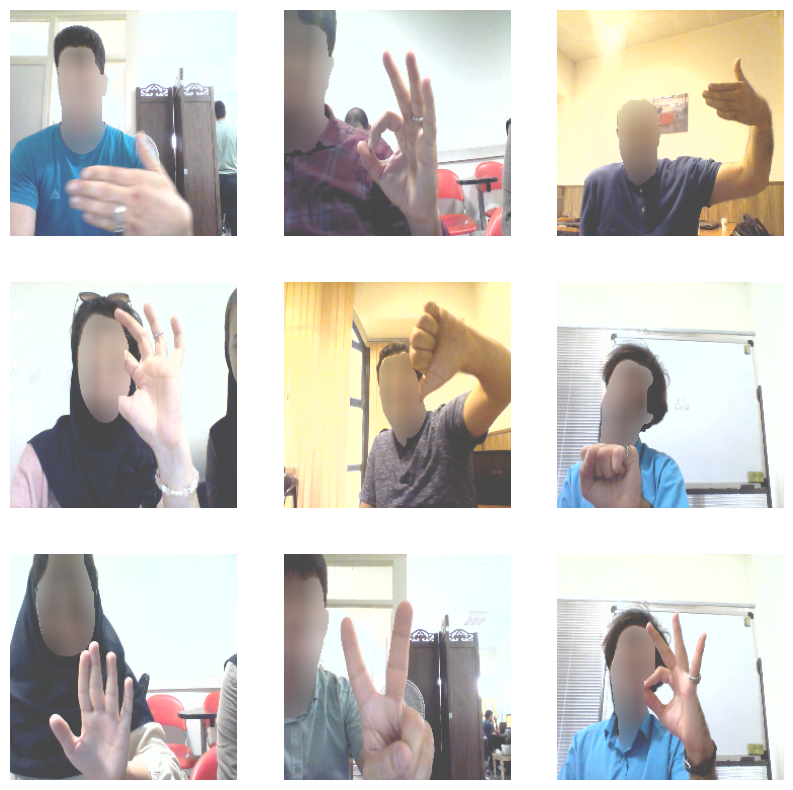

In [29]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow((image_batch[i].numpy()*255).astype('uint8'))
  plt.axis("off")

In [30]:
image_batch[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.7137255 , 0.7254902 , 0.7137255 ],
        [0.75686276, 0.72156864, 0.6901961 ],
        [0.7529412 , 0.73333335, 0.68235296],
        ...,
        [0.94509804, 1.        , 1.        ],
        [0.9372549 , 1.        , 0.99607843],
        [0.94509804, 1.        , 1.        ]],

       [[0.7607843 , 0.7529412 , 0.6901961 ],
        [0.8039216 , 0.74509805, 0.6666667 ],
        [0.7882353 , 0.74509805, 0.6784314 ],
        ...,
        [0.93333334, 1.        , 1.        ],
        [0.9411765 , 1.        , 1.        ],
        [0.9490196 , 1.        , 1.        ]],

       [[0.7529412 , 0.74509805, 0.6431373 ],
        [0.7372549 , 0.7411765 , 0.6431373 ],
        [0.72156864, 0.73333335, 0.6745098 ],
        ...,
        [0.92941177, 1.        , 1.        ],
        [0.9411765 , 1.        , 1.        ],
        [0.93333334, 1.        , 1.        ]],

       ...,

       [[0.8235294 , 0.7254902 , 0.7490196 ],
        [0.82

In [31]:
label_batch

(<tf.Tensor: shape=(64,), dtype=int32, numpy=
 array([6, 3, 6, 3, 1, 0, 2, 4, 3, 4, 7, 7, 1, 6, 5, 6, 7, 7, 6, 7, 2, 7,
        0, 7, 1, 1, 5, 6, 3, 2, 3, 6, 7, 7, 2, 7, 0, 2, 5, 7, 4, 1, 6, 7,
        3, 6, 4, 4, 6, 3, 2, 4, 0, 5, 0, 6, 5, 1, 1, 0, 6, 3, 3, 0],
       dtype=int32)>,
 <tf.Tensor: shape=(64, 4), dtype=float32, numpy=
 array([[0.517857, 0.774554, 0.5625  , 0.450893],
        [0.526786, 0.537946, 0.410714, 0.763393],
        [0.785714, 0.363839, 0.3125  , 0.316964],
        [0.609375, 0.379464, 0.370536, 0.598214],
        [0.674107, 0.34375 , 0.321429, 0.553571],
        [0.236607, 0.850446, 0.339286, 0.299107],
        [0.357143, 0.689732, 0.428571, 0.602679],
        [0.430804, 0.604911, 0.477679, 0.790179],
        [0.53125 , 0.542411, 0.375   , 0.558036],
        [0.783482, 0.600446, 0.227679, 0.59375 ],
        [0.379464, 0.582589, 0.232143, 0.40625 ],
        [0.433036, 0.59375 , 0.526786, 0.8125  ],
        [0.299107, 0.533482, 0.232143, 0.370536],
        [0.4799

Model

In [32]:
vgg = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [33]:
flatten = vgg.output
flatten = Flatten()(flatten)

# bounding box coordinates
bboxHead = Dense(128, activation="relu")(flatten)
bboxHead = Dense(64, activation="relu")(bboxHead)
bboxHead = Dense(32, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)


# the class label
softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.5)(softmaxHead)
softmaxHead = Dense(8, activation="softmax", name="class_label")(softmaxHead)

model = Model(inputs=vgg.input, outputs=(softmaxHead, bboxHead))

In [34]:
vgg.trainable = False

In [35]:
losses = {
    "class_label": "sparse_categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

In [36]:
def iou_metric(y_true, y_pred):

    xA1, yA1, xA2, yA2 = y_true[:, 0] - y_true[:, 2] / 2, y_true[:, 1] - y_true[:, 3] / 2, \
                          y_true[:, 0] + y_true[:, 2] / 2, y_true[:, 1] + y_true[:, 3] / 2
    xB1, yB1, xB2, yB2 = y_pred[:, 0] - y_pred[:, 2] / 2, y_pred[:, 1] - y_pred[:, 3] / 2, \
                          y_pred[:, 0] + y_pred[:, 2] / 2, y_pred[:, 1] + y_pred[:, 3] / 2

    xI1, yI1, xI2, yI2 = tf.maximum(xA1, xB1), tf.maximum(yA1, yB1), tf.minimum(xA2, xB2), tf.minimum(yA2, yB2)
    inter_area = tf.maximum(0.0, xI2 - xI1) * tf.maximum(0.0, yI2 - yI1)

    boxA_area = (xA2 - xA1) * (yA2 - yA1)
    boxB_area = (xB2 - xB1) * (yB2 - yB1)

    iou = inter_area / (boxA_area + boxB_area - inter_area + 1e-9)
    return tf.reduce_mean(iou)


In [40]:
metrics = {
    "class_label": ["accuracy"],
    "bounding_box": [iou_metric]
}

In [44]:
opt = Adam(learning_rate=1e-4)
model.compile(
    loss=losses,
    optimizer=opt,
    metrics=metrics,
    loss_weights=lossWeights
)

In [42]:
from keras.callbacks import ReduceLROnPlateau
reducelr = ReduceLROnPlateau('bounding_box_loss', 0.1, 2, min_lr=1e-6)

Training

In [45]:
H = model.fit(
train_ds,
validation_data= val_ds,
epochs=10,
callbacks=[reducelr])

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 59s 368ms/step - bounding_box_iou_metric: 0.4233 - bounding_box_loss: 0.0145 - class_label_accuracy: 0.2215 - class_label_loss: 2.0780 - loss: 2.0926 - val_bounding_box_iou_metric: 0.6020 - val_bounding_box_loss: 0.0043 - val_class_label_accuracy: 0.6703 - val_class_label_loss: 1.2313 - val_loss: 1.2356 - learning_rate: 1.0000e-04
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 58s 357ms/step - bounding_box_iou_metric: 0.6306 - bounding_box_loss: 0.0036 - class_label_accuracy: 0.5328 - class_label_loss: 1.3079 - loss: 1.3114 - val_bounding_box_iou_metric: 0.6579 - val_bounding_box_loss: 0.0028 - val_class_label_accuracy: 0.8172 - val_class_label_loss: 0.7305 - val_loss: 0.7333 - learning_rate: 1.0000e-04
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 31s 347ms/step - bounding_box_iou_metric: 0.6932 - bounding_box_loss: 0.0021 - class_label_accuracy: 0.7089 - class_label_loss: 0.8442 - loss: 0.8464 - val_bounding_box_iou_metric: 0.6950 - val_bounding_box_loss: 0.0022 

In [46]:
vgg.trainable = True

In [47]:
for layer in vgg.layers[:14]:
    if layer.trainable:
        layer.trainable = False

In [48]:
opt = Adam(learning_rate=1e-5)
model.compile(
    loss=losses,
    optimizer=opt,
    metrics=metrics,
    loss_weights=lossWeights
)

In [49]:
model.fit(
train_ds,
validation_data= val_ds,
epochs=10,
callbacks=[reducelr])

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 49s 421ms/step - bounding_box_iou_metric: 0.7987 - bounding_box_loss: 7.2921e-04 - class_label_accuracy: 0.9726 - class_label_loss: 0.0909 - loss: 0.0916 - val_bounding_box_iou_metric: 0.7604 - val_bounding_box_loss: 0.0013 - val_class_label_accuracy: 0.9859 - val_class_label_loss: 0.0655 - val_loss: 0.0668 - learning_rate: 1.0000e-05
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 74s 418ms/step - bounding_box_iou_metric: 0.8036 - bounding_box_loss: 6.9948e-04 - class_label_accuracy: 0.9844 - class_label_loss: 0.0581 - loss: 0.0588 - val_bounding_box_iou_metric: 0.7616 - val_bounding_box_loss: 0.0012 - val_class_label_accuracy: 0.9844 - val_class_label_loss: 0.0669 - val_loss: 0.0681 - learning_rate: 1.0000e-05
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 418ms/step - bounding_box_iou_metric: 0.8116 - bounding_box_loss: 6.3311e-04 - class_label_accuracy: 0.9907 - class_label_loss: 0.0391 - loss: 0.0398 - val_bounding_box_iou_metric: 0.7631 - val_bounding_box_l

In [77]:
model.save_weights('model.weights.h5')

Prediction

In [50]:
decode_predictions = {0:'zero', 1:'dislike', 2:'five', 3:'exactly', 4:'two', 5:'three', 6:'left', 7:'like'}

In [51]:
def draw_bbox(img, boxPreds, lbl):
    image = np.copy(img)
    (h, w) = image.shape[:2]

    # predict the bounding box of the object along with the class label
    (X, Y, dX, dY) = boxPreds[0]

    # scale the predicted bounding box coordinates based on the image
    # dimensions
    X = X * w
    Y = Y * h
    dX = dX * w
    dY = dY * h
    startX = int(X - dX/2)
    startY = int(Y - dY/2)
    endX = int(X + dX/2)
    endY = int(Y + dY/2)
    # draw the predicted bounding box and class label on the image
    cv2.putText(image, lbl, (startX, startY), cv2.FONT_HERSHEY_SIMPLEX,
        0.65, (0, 0, 0), 2)
    cv2.rectangle(image, (startX, startY+5), (endX, endY),
        (0, 0, 0), 2)

    return image

In [74]:
test_path = '/content/test/zero/10747.png'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


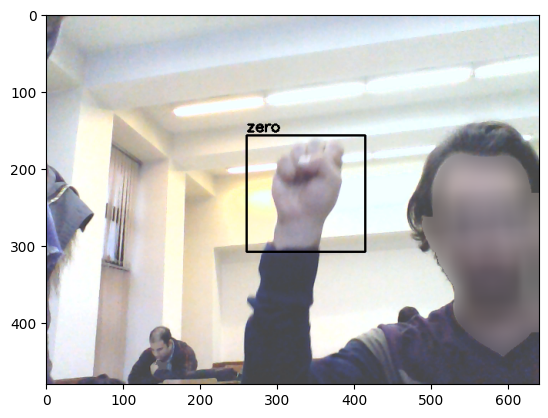

In [75]:
image = load_img(test_path, target_size=(224, 224))
image_show = plt.imread(test_path)
image = img_to_array(image) / 255.0
image = np.expand_dims(image, axis=0)
lbl, box = model.predict(image)
pred_class = decode_predictions[np.argmax(lbl)]
img = draw_bbox(image_show, box, pred_class)
plt.imshow(img)

Analysis

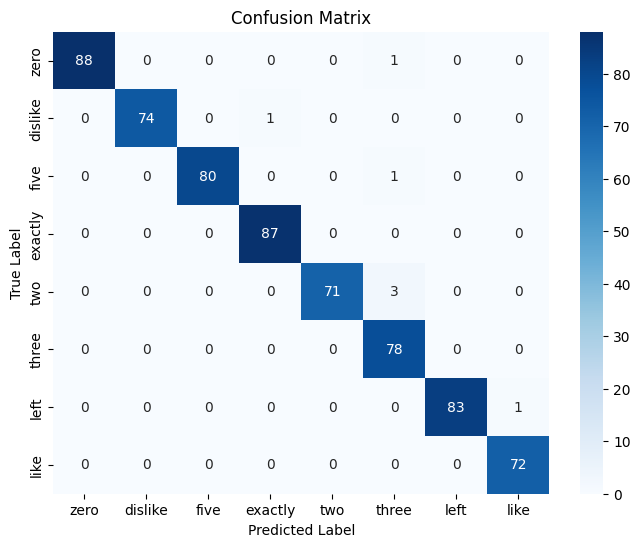

              precision    recall  f1-score   support

        zero       1.00      0.99      0.99        89
     dislike       1.00      0.99      0.99        75
        five       1.00      0.99      0.99        81
     exactly       0.99      1.00      0.99        87
         two       1.00      0.96      0.98        74
       three       0.94      1.00      0.97        78
        left       1.00      0.99      0.99        84
        like       0.99      1.00      0.99        72

    accuracy                           0.99       640
   macro avg       0.99      0.99      0.99       640
weighted avg       0.99      0.99      0.99       640



In [83]:
true_labels = []
pred_labels = []

for images, labels in val_ds:
    lbls_true = labels[0].numpy()
    lbls_pred, _ = model.predict(images, verbose=0)

    true_labels.extend(lbls_true)
    pred_labels.extend(np.argmax(lbls_pred, axis=1))

cm = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=decode_predictions.values(), yticklabels=decode_predictions.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print(classification_report(true_labels, pred_labels, target_names=decode_predictions.values()))